<a href="https://colab.research.google.com/github/raulocp9/TSC/blob/master/Ejemplo_con_Ingenier%C3%ADa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.feature_selection import f_regression
from sklearn.neural_network import MLPRegressor

from varclushi import VarClusHi
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns 
import cufflinks as cf

from glob import glob

from functools import reduce
from itertools import combinations
cf.go_offline()
pd.set_option('display.max_columns',None)

## Carga de datos

In [ ]:
ruta = '/media/jose/090f6b94-de30-4aaf-9f8a-4e18b120d7f6/bd/stocks/full_history/*.csv'

In [ ]:
archivos = sorted(glob(ruta))

In [ ]:
muestra = np.random.choice(archivos,size=int(len(archivos)*0.03),replace=False)

In [ ]:
len(muestra)

In [ ]:
arch = muestra[0]
arch

In [ ]:
def leerArchivo(arch:str)->pd.DataFrame:
    df = pd.read_csv(arch).drop('adjclose',axis=1)
    df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d',errors='coerce')
    nombre = arch.split('/')[-1].split('.')[0]
    df.insert(0,'stock',nombre)
    return df


In [ ]:
datos = pd.concat(map(leerArchivo,muestra),ignore_index=True).drop_duplicates().reset_index(drop=True)

## Ingeniería de características

In [ ]:
catfh = datos[['date']].drop_duplicates().sort_values(by='date').reset_index(drop=True)
catfh['sem'] = catfh['date'].map(lambda x:x.strftime('%Y%U'))
catfh = catfh[['sem']].drop_duplicates().sort_values(by='sem',ascending=False).reset_index(drop=True)
catfh['id_sem'] = catfh.index+1
catfh

In [ ]:
datos['sem'] = datos['date'].map(lambda x:x.strftime('%Y%U'))
datos = datos.merge(catfh,on='sem',how='inner').drop('sem',axis=1)

In [ ]:
datos = datos[datos['id_sem']<=120].reset_index(drop=True)

In [ ]:
datos.shape

In [ ]:
datos[['id_sem','open']].groupby('id_sem').count().iplot(kind='line',color='purple')

In [ ]:
vobs,vdes = 4,1
ini, fin = datos['id_sem'].min(),datos['id_sem'].max()
anclai,anclaf = ini+vdes,fin-vobs+1
anclai,anclaf 

In [ ]:
for ancla in range(anclai,anclaf+1):
    print(f"Para predecir el ancla {ancla-vdes} voy a usar la ventana {list(range(ancla,ancla+vobs))}")

### Matriz de predictoras $\mathcal{X}$

In [ ]:
var = ['volume','open','high','low','close','dif']

In [ ]:
datos['dif'] = datos['high']-datos['low']

In [ ]:
for u,v in combinations(var,2):
    nombre = f'ratio_{u}_{v}'
    datos[nombre] = datos[v]/datos[u]
    var.append(nombre)

In [ ]:
def ingX(datos:pd.DataFrame,ancla:int)->pd.DataFrame:
    aux = datos[(datos['id_sem']>=ancla)&(datos['id_sem']<=(ancla+vobs-1))].copy().reset_index(drop=True)
    funciones = [np.min,np.max,np.median,np.mean]
    nombres = ['min','max','mediana','media']
    l = []
    for f,n in zip(funciones,nombres):
        agg = aux.drop('date',axis=1).groupby('stock').agg({v:f for v in var})
        agg.columns = [f'x_{n}_{c}' for c in agg.columns]
        l.append(agg.reset_index())
    aux = reduce(lambda x,y:x.merge(y,on='stock',how='outer'),l)
    aux.insert(1,'ancla',ancla)
    return aux

In [ ]:
um = ['stock','ancla']

In [ ]:
X = pd.concat(map(lambda ancla:ingX(datos,ancla),range(anclai,anclaf+1)),ignore_index=True)

### Variable objetivo $\vec{y}$

In [ ]:
def ingy(datos:pd.DataFrame,ancla:int)->pd.DataFrame:
    aux = datos[(datos['id_sem']==(ancla-vdes))].copy().reset_index(drop=True)
    aux = aux[['stock','close']].groupby('stock').max().reset_index().rename(columns={'close':'target'})
    aux.insert(1,'ancla',ancla)
    return aux

In [ ]:
y = pd.concat(map(lambda ancla:ingy(datos,ancla),range(anclai,anclaf+1)),ignore_index=True)

### Tabla Analítica de Datos (TAD), $S_n = \{(x^{(i)},y^{(i)}),i=1,\ldots,n\}$

In [ ]:
Sn = X.merge(y,on=um,how='inner')
Sn.shape

In [ ]:
Sn.head()

In [ ]:
Sn.to_parquet('Sn.parquet')

In [ ]:
Sn.to_pickle('Sn.pickle')

In [ ]:
Sn = pd.read_pickle('Sn.pickle')

### Partición

In [ ]:
train, valid = train_test_split(Sn,train_size=0.7)
train.reset_index(drop=True,inplace=True),valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((15475, 87), (6633, 87))

## Análisis Exploratorio de datos

### Reducción de dimensiones

#### Multicolinealidad

In [ ]:
var = sorted(train.filter(like='x_').columns)
len(var)

84

In [ ]:
vc = VarClusHi(df=train,feat_list=var).varclus()

In [ ]:
vc.rsquare

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,x_media_ratio_close_dif,0.993352,0.789691,0.031613
1,0,x_media_ratio_high_close,0.942302,0.699843,0.192226
2,0,x_media_ratio_high_dif,0.993826,0.752258,0.024922
3,0,x_media_ratio_high_low,0.993826,0.752258,0.024922
4,0,x_media_ratio_low_close,0.881238,0.782164,0.545191
...,...,...,...,...,...
79,8,x_max_ratio_open_low,0.496123,0.166155,0.604282
80,8,x_min_ratio_low_close,0.589321,0.263371,0.557512
81,8,x_min_ratio_open_high,0.719156,0.131583,0.323397
82,9,x_mediana_ratio_open_close,1.000000,0.517958,0.000000


In [ ]:
var = list(vc.rsquare.sort_values(by=['Cluster','RS_Ratio']).groupby('Cluster').first()['Variable'])

In [ ]:
len(var)

11

In [ ]:
var

['x_media_ratio_high_low',
 'x_min_ratio_volume_high',
 'x_media_open',
 'x_max_ratio_volume_open',
 'x_media_volume',
 'x_min_ratio_open_dif',
 'x_media_ratio_volume_dif',
 'x_max_ratio_open_dif',
 'x_min_ratio_open_high',
 'x_mediana_ratio_open_close',
 'x_media_ratio_open_close']

### Análisis Univariado

#### Continuo

##### Distribución

array([[<Axes: title={'center': 'x_media_ratio_high_low'}>,
        <Axes: title={'center': 'x_min_ratio_volume_high'}>,
        <Axes: title={'center': 'x_media_open'}>],
       [<Axes: title={'center': 'x_max_ratio_volume_open'}>,
        <Axes: title={'center': 'x_media_volume'}>,
        <Axes: title={'center': 'x_min_ratio_open_dif'}>],
       [<Axes: title={'center': 'x_media_ratio_volume_dif'}>,
        <Axes: title={'center': 'x_max_ratio_open_dif'}>,
        <Axes: title={'center': 'x_min_ratio_open_high'}>],
       [<Axes: title={'center': 'x_mediana_ratio_open_close'}>,
        <Axes: title={'center': 'x_media_ratio_open_close'}>, <Axes: >]],
      dtype=object)

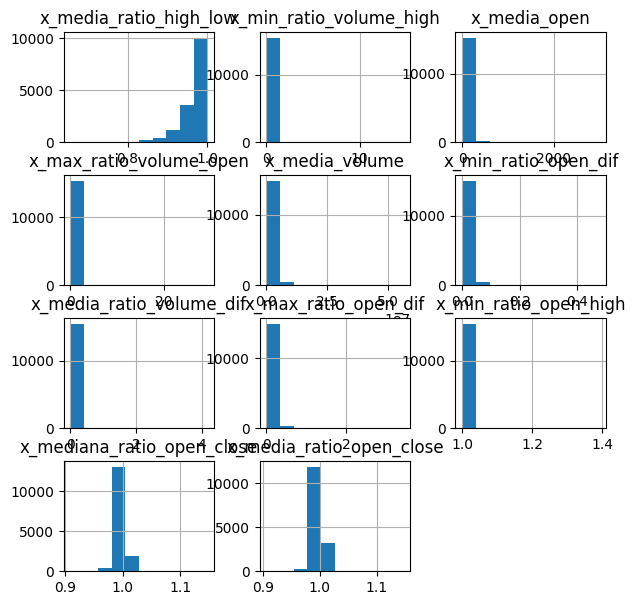

In [ ]:
train[var].hist(figsize=(7,7))

##### Ausentes

In [ ]:
(train[var].isna().sum()/len(train)).to_frame()

,0
x_media_ratio_high_low,0.0
x_min_ratio_volume_high,0.0
x_media_open,0.0
x_max_ratio_volume_open,0.0
x_media_volume,0.0
x_min_ratio_open_dif,0.0
x_media_ratio_volume_dif,0.0
x_max_ratio_open_dif,0.0
x_min_ratio_open_high,0.0
x_mediana_ratio_open_close,0.0


##### Extremos

In [ ]:
for v,li,ls in train[var].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    train[f'ex_{v}'] = ((train[v]<li)|(train[v]>ls)).astype(int)

In [ ]:
train['ex_'] = train.filter(like='ex_').max(axis=1)

In [ ]:
train['ex_'].value_counts(1)

0    0.899257
1    0.100743
Name: ex_, dtype: float64

In [ ]:
train = train[train['ex_']==0].reset_index(drop=True)

In [ ]:
train.drop(train.filter(like='ex_').columns,axis=1,inplace=True)

array([[<Axes: title={'center': 'x_media_ratio_high_low'}>,
        <Axes: title={'center': 'x_min_ratio_volume_high'}>,
        <Axes: title={'center': 'x_media_open'}>],
       [<Axes: title={'center': 'x_max_ratio_volume_open'}>,
        <Axes: title={'center': 'x_media_volume'}>,
        <Axes: title={'center': 'x_min_ratio_open_dif'}>],
       [<Axes: title={'center': 'x_media_ratio_volume_dif'}>,
        <Axes: title={'center': 'x_max_ratio_open_dif'}>,
        <Axes: title={'center': 'x_min_ratio_open_high'}>],
       [<Axes: title={'center': 'x_mediana_ratio_open_close'}>,
        <Axes: title={'center': 'x_media_ratio_open_close'}>, <Axes: >]],
      dtype=object)

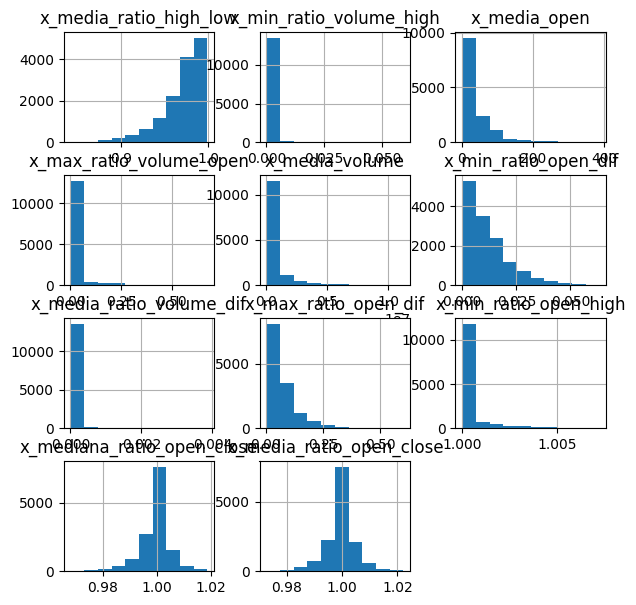

In [ ]:
train[var].hist(figsize=(7,7))

<Axes: >

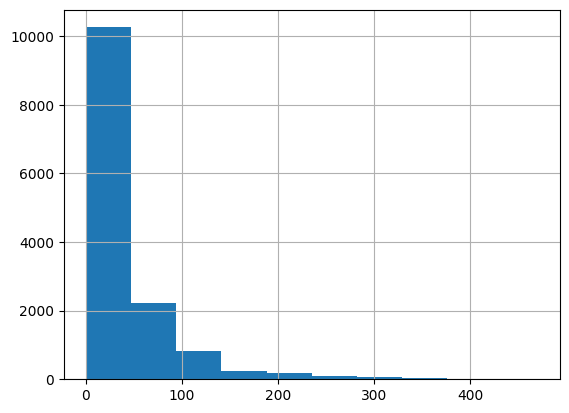

In [ ]:
train['target'].hist()

In [ ]:
train[var].describe(percentiles=[0.01,0.05,0.95,0.99])

,x_media_ratio_high_low,x_min_ratio_volume_high,x_media_open,x_max_ratio_volume_open,x_media_volume,x_min_ratio_open_dif,x_media_ratio_volume_dif,x_max_ratio_open_dif,x_min_ratio_open_high,x_mediana_ratio_open_close,x_media_ratio_open_close
count,13916.000000,1.391600e+04,13916.000000,13916.000000,1.391600e+04,13916.000000,1.391600e+04,13916.000000,13916.000000,13916.000000,13916.000000
mean,0.970794,7.211126e-04,39.486557,0.019981,7.218674e+05,0.011699,4.111856e-05,0.072059,1.000367,0.999271,0.999491
std,0.024193,2.893994e-03,48.194599,0.064397,1.485080e+06,0.010871,1.511051e-04,0.071949,0.001002,0.005664,0.005484
min,0.842344,1.569439e-07,0.760000,0.000001,2.500000e+02,0.000000,2.030807e-08,0.001985,1.000000,0.968067,0.972708
1%,0.888974,4.389183e-07,1.021642,0.000003,6.008333e+02,0.000000,5.697202e-08,0.004002,1.000000,0.979492,0.981932
5%,0.920577,1.583221e-06,2.626454,0.000010,1.938221e+03,0.000000,1.439786e-07,0.008248,1.000000,0.988678,0.989826
50%,0.977200,6.248313e-05,23.614577,0.000515,1.437101e+05,0.009155,4.428136e-06,0.050245,1.000000,1.000000,0.999839
95%,0.996440,3.391280e-03,126.867453,0.137408,3.780005e+06,0.033489,1.847461e-04,0.215142,1.002561,1.007463,1.007988
99%,0.998655,1.260194e-02,257.871527,0.368857,7.758910e+06,0.049180,6.000529e-04,0.346492,1.005154,1.013574,1.014603
max,0.999277,5.915000e-02,386.355263,0.677100,1.125867e+07,0.063291,3.859714e-03,0.600000,1.007194,1.018634,1.022130


#### Híper-Caja $X_{[0,1]}$

In [ ]:
scx = MinMaxScaler()
scy = MinMaxScaler()

In [ ]:
y01 = pd.DataFrame(scy.fit_transform(train[['target']]),columns=['target'])

In [ ]:
X01 = pd.DataFrame(scx.fit_transform(train[var]),columns=var)
X01.describe()

,x_media_ratio_high_low,x_min_ratio_volume_high,x_media_open,x_max_ratio_volume_open,x_media_volume,x_min_ratio_open_dif,x_media_ratio_volume_dif,x_max_ratio_open_dif,x_min_ratio_open_high,x_mediana_ratio_open_close,x_media_ratio_open_close
count,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000,13916.000000
mean,0.818504,0.012189,0.100433,0.029508,0.064096,0.184840,0.010648,0.117178,0.050995,0.617085,0.541922
std,0.154163,0.048926,0.124988,0.095107,0.131908,0.171769,0.039149,0.120313,0.139278,0.112013,0.110955
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.755066,0.000209,0.026962,0.000122,0.002764,0.052563,0.000255,0.037076,0.000000,0.583349,0.500938
50%,0.859322,0.001054,0.059271,0.000759,0.012742,0.144650,0.001142,0.080701,0.000000,0.631503,0.548971
75%,0.932193,0.004741,0.124075,0.005289,0.055342,0.262771,0.005231,0.153713,0.000000,0.665138,0.588853
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Análisis de poder predictivo

In [ ]:
#sk = SelectKBest(k=len(var),score_func=f_regression)
sk = SelectKBest(k=3)

In [ ]:
sk.fit(X01[var],y01['target'])

SelectKBest(k=3)

In [ ]:
sk.scores_

array([  1.31818542,   2.61965547, 665.06144781,   2.5230803 ,
         1.1446985 ,   0.96009078,   2.35559481,   1.26201131,
         1.17666825,   0.83784066,   0.82436301])

In [ ]:
pd.Series(dict(zip(sk.get_feature_names_out(),sk.scores_)))

x_min_ratio_volume_high      1.318185
x_media_open                 2.619655
x_max_ratio_volume_open    665.061448
dtype: float64

In [ ]:
best = [v for v,d in zip(var,sk.get_support()) if d ]

In [ ]:
best

['x_min_ratio_volume_high', 'x_media_open', 'x_max_ratio_volume_open']

## Representación Vectorial

In [ ]:
pipe = make_pipeline(StandardScaler(),PCA(),MinMaxScaler())

In [ ]:
Z = pd.DataFrame(pipe.fit_transform(train[best]))

In [ ]:
Z.corr().round(1)

,0,1,2
0,1.0,-0.0,-0.0
1,-0.0,1.0,0.0
2,-0.0,0.0,1.0


array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: >]], dtype=object)

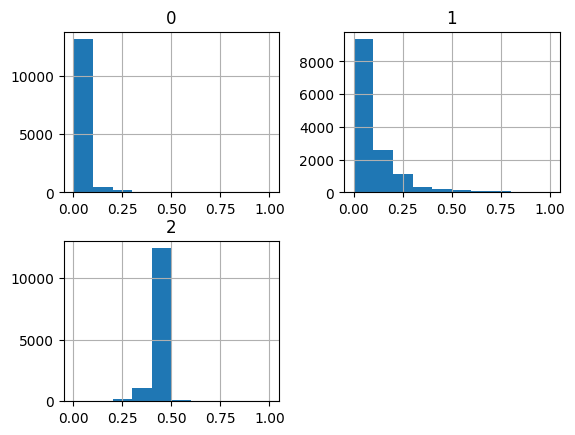

In [ ]:
Z.hist()

## Aprendizaje

In [ ]:
ann = MLPRegressor()

### Híper-parametrización

In [ ]:
hiper_param = {'hidden_layer_sizes':[(a,b,) for a in range(5,10) for b in range(5,10)],
               'learning_rate':['constant', 'invscaling', 'adaptive'],
               'activation':['relu','tanh','sigmoid']}

In [ ]:
reduce(lambda x,y:x*y,map(len,hiper_param.values()))

225

In [ ]:
grid = GridSearchCV(param_grid=hiper_param, n_jobs=-1,
                    estimator=ann, cv=5, verbose=True, scoring='neg_mean_absolute_error')


In [ ]:
grid.fit(Z,y01['target'])

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


/home/jose/entornos/tsc2/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


375 fits failed out of a total of 1125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
91 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jose/entornos/tsc2/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jose/entornos/tsc2/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py", line 745, in fit
    self._validate_params()
  File "/home/jose/entornos/tsc2/lib/python3.10/site-packages/sklearn/base.py", line 581, in _validate_params
    validate_par

GridSearchCV(cv=5, estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh', 'sigmoid'],
                         'hidden_layer_sizes': [(5, 5), (5, 6), (5, 7), (5, 8),
                                                (5, 9), (6, 5), (6, 6), (6, 7),
                                                (6, 8), (6, 9), (7, 5), (7, 6),
                                                (7, 7), (7, 8), (7, 9), (8, 5),
                                                (8, 6), (8, 7), (8, 8), (8, 9),
                                                (9, 5), (9, 6), (9, 7), (9, 8),
                                                (9, 9)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             scoring='neg_mean_absolute_error', verbose=True)

In [ ]:
ann = grid.best_estimator_
ann

MLPRegressor(hidden_layer_sizes=(8, 7), learning_rate='invscaling')

In [ ]:
grid.best_score_

-0.005176309967286721

### Parámetros $\vec{\theta}$

In [ ]:
ann.fit(Z,y01['target'])

MLPRegressor(hidden_layer_sizes=(8, 7), learning_rate='invscaling')

In [ ]:
ann.coefs_

[array([[ 4.48360666e-01,  3.03342885e-01, -8.42211708e-02,
          2.31533015e-01,  6.48580927e-01, -7.30918639e-01,
          6.76089583e-30,  1.51098160e-04],
        [-4.98692432e-01, -5.55100750e-01, -3.17836665e-01,
          5.76400688e-01, -3.63941923e-01, -2.22770168e-01,
         -3.89836034e-06, -3.19784483e-04],
        [ 3.20573038e-01,  2.25327523e-01,  1.23254844e-01,
          5.53004795e-01, -4.35871382e-01, -1.09799502e-01,
         -6.44624654e-04, -4.79567327e-08]]),
 array([[ 4.84204872e-12,  2.30571009e-01,  2.73230770e-06,
          1.85243389e-02,  7.69844616e-05,  3.79853380e-01,
         -5.76798908e-02],
        [ 5.33051526e-06,  2.41769994e-01, -1.65996041e-22,
          1.02071772e-01, -2.65440847e-09,  1.48206847e-01,
          5.49932885e-01],
        [-3.75924123e-04,  4.90333202e-01,  1.03334763e-07,
          6.53873790e-01, -1.94603363e-46,  2.71306869e-01,
         -5.09597039e-02],
        [-1.20993482e-05, -3.45289510e-01, -7.67474249e-33,
     

### Métricas de ajuste

In [ ]:
Zv = pd.DataFrame(pipe.transform(valid[best]))

In [ ]:
print(mean_absolute_percentage_error(y_true=scy.inverse_transform(ann.predict(Z).reshape(-1,1)),y_pred=y01))
print(mean_absolute_error(y_true=scy.inverse_transform(ann.predict(Z).reshape(-1,1)),y_pred=y01))
print(mean_squared_error(y_true=scy.inverse_transform(ann.predict(Z).reshape(-1,1)),y_pred=y01))

0.9978588780778571
39.75453257108762
3804.5011118071748


In [ ]:
print(mean_absolute_percentage_error(y_true=scy.inverse_transform(ann.predict(Zv).reshape(-1,1)),y_pred=valid['target']))
print(mean_absolute_error(y_true=scy.inverse_transform(ann.predict(Zv).reshape(-1,1)),y_pred=valid['target']))
print(mean_squared_error(y_true=scy.inverse_transform(ann.predict(Zv).reshape(-1,1)),y_pred=valid['target']))

0.2131991500111386
14.272062411751245
8303.02513127518


In [ ]:
train['y^'] = scy.inverse_transform(ann.predict(Z).reshape(-1,1))
valid['y^'] = scy.inverse_transform(ann.predict(Zv).reshape(-1,1))

<Axes: ylabel='Density'>

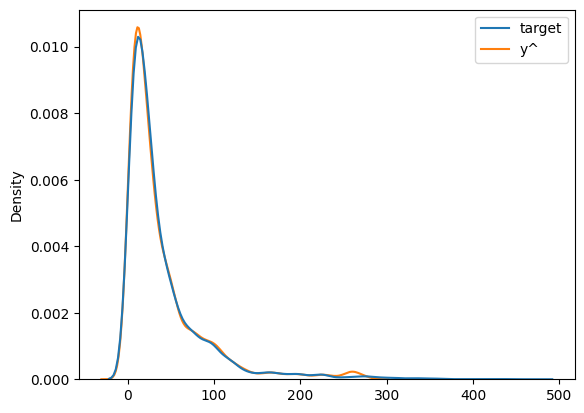

In [ ]:
plt.figure()
sns.kdeplot(train[['target','y^']])

<Axes: ylabel='Density'>

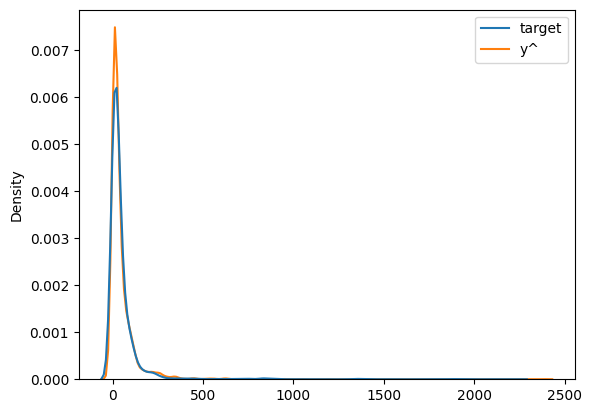

In [ ]:
plt.figure()
sns.kdeplot(valid[['target','y^']])